# Calculate Policy Derivatives with Respect to State Space

This notebook computes all derivatives of the policy with respect to each state variable.

The policy derivatives (Jacobian matrix) show how sensitive each action dimension is to changes in each state variable.


## 1. Setup and Imports


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO
import os

# Import environment and utilities
from snake_env import FixedWavelengthXZOnlyContinuumSnakeEnv
from Utilities.policy_gradient_utils import (
    compute_policy_gradient,
    compute_policy_jacobian,
    get_policy_sensitivity
)
import config

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10


## 2. Load Trained Model


In [2]:
# Path to trained model
model_path = os.path.join(config.PATHS["model_dir"], config.PATHS["model_name"])

# Check if model exists, otherwise try checkpoint
if not os.path.exists(model_path + ".zip"):
    checkpoint_path = os.path.join(config.PATHS["model_dir"], config.PATHS["checkpoint_name"])
    if os.path.exists(checkpoint_path + ".zip"):
        model_path = checkpoint_path
        print(f"Using checkpoint model: {model_path}")
    else:
        raise FileNotFoundError(f"Model not found at {model_path}.zip or {checkpoint_path}.zip")
else:
    print(f"Using model: {model_path}")

# Create environment first (needed to load model)
env = FixedWavelengthXZOnlyContinuumSnakeEnv(
    fixed_wavelength=config.ENV_CONFIG["fixed_wavelength"],
    obs_keys=config.ENV_CONFIG["obs_keys"],
)
env.period = config.ENV_CONFIG["period"]
env.ratio_time = config.ENV_CONFIG["ratio_time"]
env.rut_ratio = config.ENV_CONFIG["rut_ratio"]
env.max_episode_length = config.ENV_CONFIG["max_episode_length"]

# Load model
model = PPO.load(model_path, env=env)
print(f"Model loaded successfully!")
print(f"Action space: {env.action_space.shape}")
print(f"Observation space: {env.observation_space.shape}")


Using model: Training/Saved_Models/PPO_Snake_Model
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Model loaded successfully!
Action space: (6,)
Observation space: (62,)


## 3. Understand State Space Structure


In [3]:
# Parse state space based on observation keys
obs_keys = config.ENV_CONFIG["obs_keys"]
n_elem = env._n_elem
n_nodes = n_elem + 1

# Calculate sizes for each observation component
# Note: FixedWavelengthXZOnlyContinuumSnakeEnv filters y-components for some keys
state_component_sizes = {}
state_component_indices = {}
idx = 0

for key in obs_keys:
    if key == "avg_velocity":
        size = 2  # XZ only (2D)
    elif key == "curvature":
        size = (n_elem - 1) * 2  # XZ only (2D)
    elif key == "velocity":
        size = n_nodes * 2  # XZ only (2D)
    elif key == "tangents":
        size = n_elem * 2  # XZ only (2D)
    elif key == "position":
        size = n_nodes * 3  # Full 3D
    elif key == "director":
        size = n_elem * 9  # Full 3x3 matrices
    elif key == "avg_position":
        size = 3  # Full 3D
    elif key == "time":
        size = 1
    else:
        size = 0
    
    state_component_sizes[key] = size
    state_component_indices[key] = (idx, idx + size)
    idx += size

# Get a sample observation to verify dimensions
obs, info = env.reset()
state_dim = obs.shape[0]

print("State space structure:")
print("=" * 70)
for key, (start, end) in state_component_indices.items():
    print(f"{key:20s}: indices [{start:3d}:{end:3d}] (size: {end-start:3d})")
print("=" * 70)
print(f"Total state dimension: {state_dim}")
print(f"Action dimension: {env.action_space.shape[0]}")


State space structure:
avg_velocity        : indices [  0:  2] (size:   2)
curvature           : indices [  2: 20] (size:  18)
velocity            : indices [ 20: 42] (size:  22)
tangents            : indices [ 42: 62] (size:  20)
Total state dimension: 62
Action dimension: 6


In [4]:
# Collect sample states from the environment
num_sample_states = 10
sample_states = []

print("Collecting sample states from environment...")
obs, info = env.reset()
sample_states.append(obs.copy())

# Run a few steps to get diverse states
for i in range(num_sample_states - 1):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    sample_states.append(obs.copy())
    
    if terminated or truncated:
        obs, info = env.reset()

sample_states = np.array(sample_states)
print(f"Collected {len(sample_states)} sample states")
print(f"State shape: {sample_states[0].shape}")

# Use the first state for detailed analysis
state = sample_states[0]
print(f"\nUsing first state for derivative computation:")
print(f"State shape: {state.shape}")


Collected 10 sample states
State shape: (62,)

Using first state for derivative computation:
State shape: (62,)


## 5. Compute Full Policy Jacobian Matrix

The Jacobian matrix J has shape (action_dim, state_dim), where:
- J[i, j] = ∂action[i] / ∂state[j]
- Each row represents one action dimension
- Each column represents one state variable


In [5]:
# Compute the full Jacobian matrix using policy_gradient_utils
print("Computing policy Jacobian matrix...")
jacobian = compute_policy_jacobian(model, state)

print(f"\nJacobian matrix computed successfully!")
print(f"Jacobian shape: {jacobian.shape}")
print(f"  - Action dimension: {jacobian.shape[0]}")
print(f"  - State dimension: {jacobian.shape[1]}")
print(f"\nJacobian statistics:")
print(f"  Min: {jacobian.min():.6f}")
print(f"  Max: {jacobian.max():.6f}")
print(f"  Mean: {jacobian.mean():.6f}")
print(f"  Std: {jacobian.std():.6f}")
print(f"  Frobenius norm: {np.linalg.norm(jacobian):.6f}")
print(f"  Mean absolute value: {np.mean(np.abs(jacobian)):.6f}")


Computing policy Jacobian matrix...

Jacobian matrix computed successfully!
Jacobian shape: (6, 62)
  - Action dimension: 6
  - State dimension: 62

Jacobian statistics:
  Min: -0.114356
  Max: 0.071597
  Mean: 0.000948
  Std: 0.024932
  Frobenius norm: 0.481222
  Mean absolute value: 0.019568


## 6. Compute Additional Gradient Information


In [6]:
# Compute comprehensive gradient information
grad_info = compute_policy_gradient(
    model,
    state,
    wrt_action_mean=True,
    wrt_value=True
)

print("Gradient information:")
print(f"Action mean shape: {grad_info['action_mean'].shape}")
print(f"Action mean: {grad_info['action_mean'].flatten()}")
print(f"\nValue estimate: {grad_info['value'][0, 0]:.6f}")
print(f"\nAction mean gradient shape: {grad_info['action_mean_grad'].shape}")
print(f"Value gradient shape: {grad_info['value_grad'].shape}")
print(f"\nValue gradient norm: {np.linalg.norm(grad_info['value_grad']):.6f}")


Gradient information:
Action mean shape: (1, 6)
Action mean: [-0.13989416 -0.00021676  0.05129696 -0.03122674 -0.07128606  0.00169402]

Value estimate: 100.867729

Action mean gradient shape: (6, 62)
Value gradient shape: (62,)

Value gradient norm: 0.318840


## 7. Visualize Full Jacobian Matrix


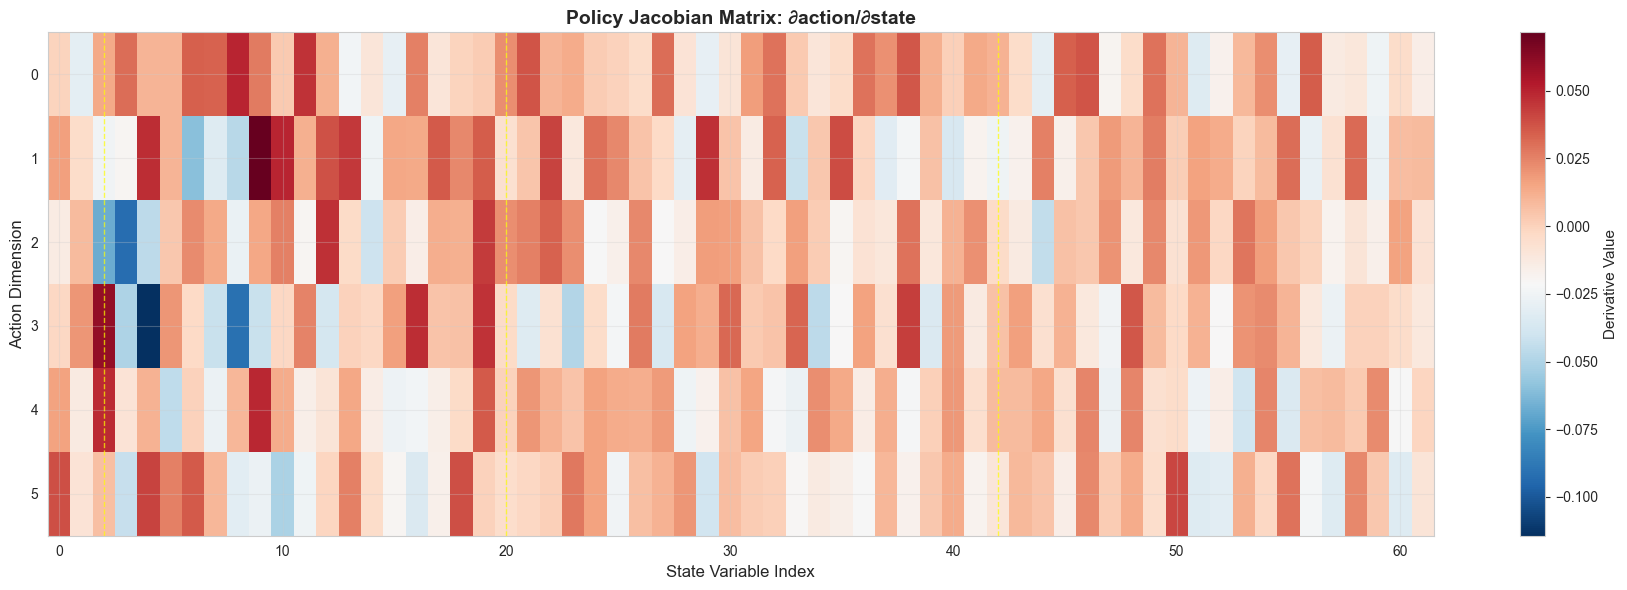


Example derivatives (first 5 actions, first 10 state variables):
[[-5.49999066e-04 -3.02981213e-02  1.37640918e-02  3.03356759e-02
   1.05670504e-02  1.04041556e-02  3.44235376e-02  3.32671553e-02
   4.97131124e-02  2.68523302e-02]
 [ 1.70411728e-02 -4.37202491e-03 -2.49679275e-02 -1.98962614e-02
   4.70828861e-02  1.05186906e-02 -6.02724515e-02 -3.33639830e-02
  -4.70842682e-02  7.15967864e-02]
 [-1.36381006e-02  8.07164330e-03 -6.75887093e-02 -9.25567895e-02
  -4.58506979e-02  3.53436219e-03  2.27005854e-02  1.36821866e-02
  -2.77399011e-02  1.47588607e-02]
 [-2.25660112e-03  1.96605679e-02  6.04619831e-02 -5.04190400e-02
  -1.14355877e-01  1.94762778e-02 -2.54950696e-03 -4.18899432e-02
  -9.10500437e-02 -4.18185033e-02]
 [ 1.61527134e-02 -1.27483327e-02  4.76641953e-02 -8.69732630e-03
   1.09340465e-02 -4.47756276e-02 -5.27193770e-05 -2.71445774e-02
   9.83204786e-03  4.84154001e-02]]


In [7]:
# Create a heatmap of the Jacobian matrix
fig, ax = plt.subplots(figsize=(18, 6))

im = ax.imshow(jacobian, aspect='auto', cmap='RdBu_r', interpolation='nearest')
ax.set_xlabel('State Variable Index', fontsize=12)
ax.set_ylabel('Action Dimension', fontsize=12)
ax.set_title('Policy Jacobian Matrix: ∂action/∂state', fontsize=14, fontweight='bold')

# Add vertical lines to separate state components
for key, (start, end) in state_component_indices.items():
    if start > 0:
        ax.axvline(x=start, color='yellow', linestyle='--', linewidth=1, alpha=0.7)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Derivative Value', fontsize=11)

# Add grid
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some example derivatives
print("\nExample derivatives (first 5 actions, first 10 state variables):")
print(jacobian[:5, :10])


## 8. Derivatives by State Component

Analyze how sensitive the policy is to each state component (e.g., velocity, curvature, etc.)


In [8]:
# Compute statistics for each state component
component_stats = {}

for key, (start, end) in state_component_indices.items():
    component_jacobian = jacobian[:, start:end]
    
    component_stats[key] = {
        'mean': np.mean(np.abs(component_jacobian)),
        'std': np.std(component_jacobian),
        'max': np.max(np.abs(component_jacobian)),
        'norm': np.linalg.norm(component_jacobian),
        'size': end - start,
        'jacobian': component_jacobian.copy()
    }

# Print statistics
print("Derivative statistics by state component:")
print("=" * 90)
print(f"{'Component':<20s} {'Size':<8s} {'Mean |∂|':<12s} {'Max |∂|':<12s} {'Std':<12s} {'Norm':<12s}")
print("=" * 90)
for key, stats in component_stats.items():
    print(f"{key:<20s} {stats['size']:<8d} {stats['mean']:<12.6f} {stats['max']:<12.6f} {stats['std']:<12.6f} {stats['norm']:<12.6f}")
print("=" * 90)


Derivative statistics by state component:
Component            Size     Mean |∂|     Max |∂|      Std          Norm        
avg_velocity         2        0.014339     0.038774     0.017813     0.062208    
curvature            18       0.026862     0.114356     0.034033     0.353712    
velocity             22       0.017189     0.048507     0.020697     0.238959    
tangents             20       0.016142     0.044120     0.019470     0.213287    


## 9. Visualize Derivatives by State Component


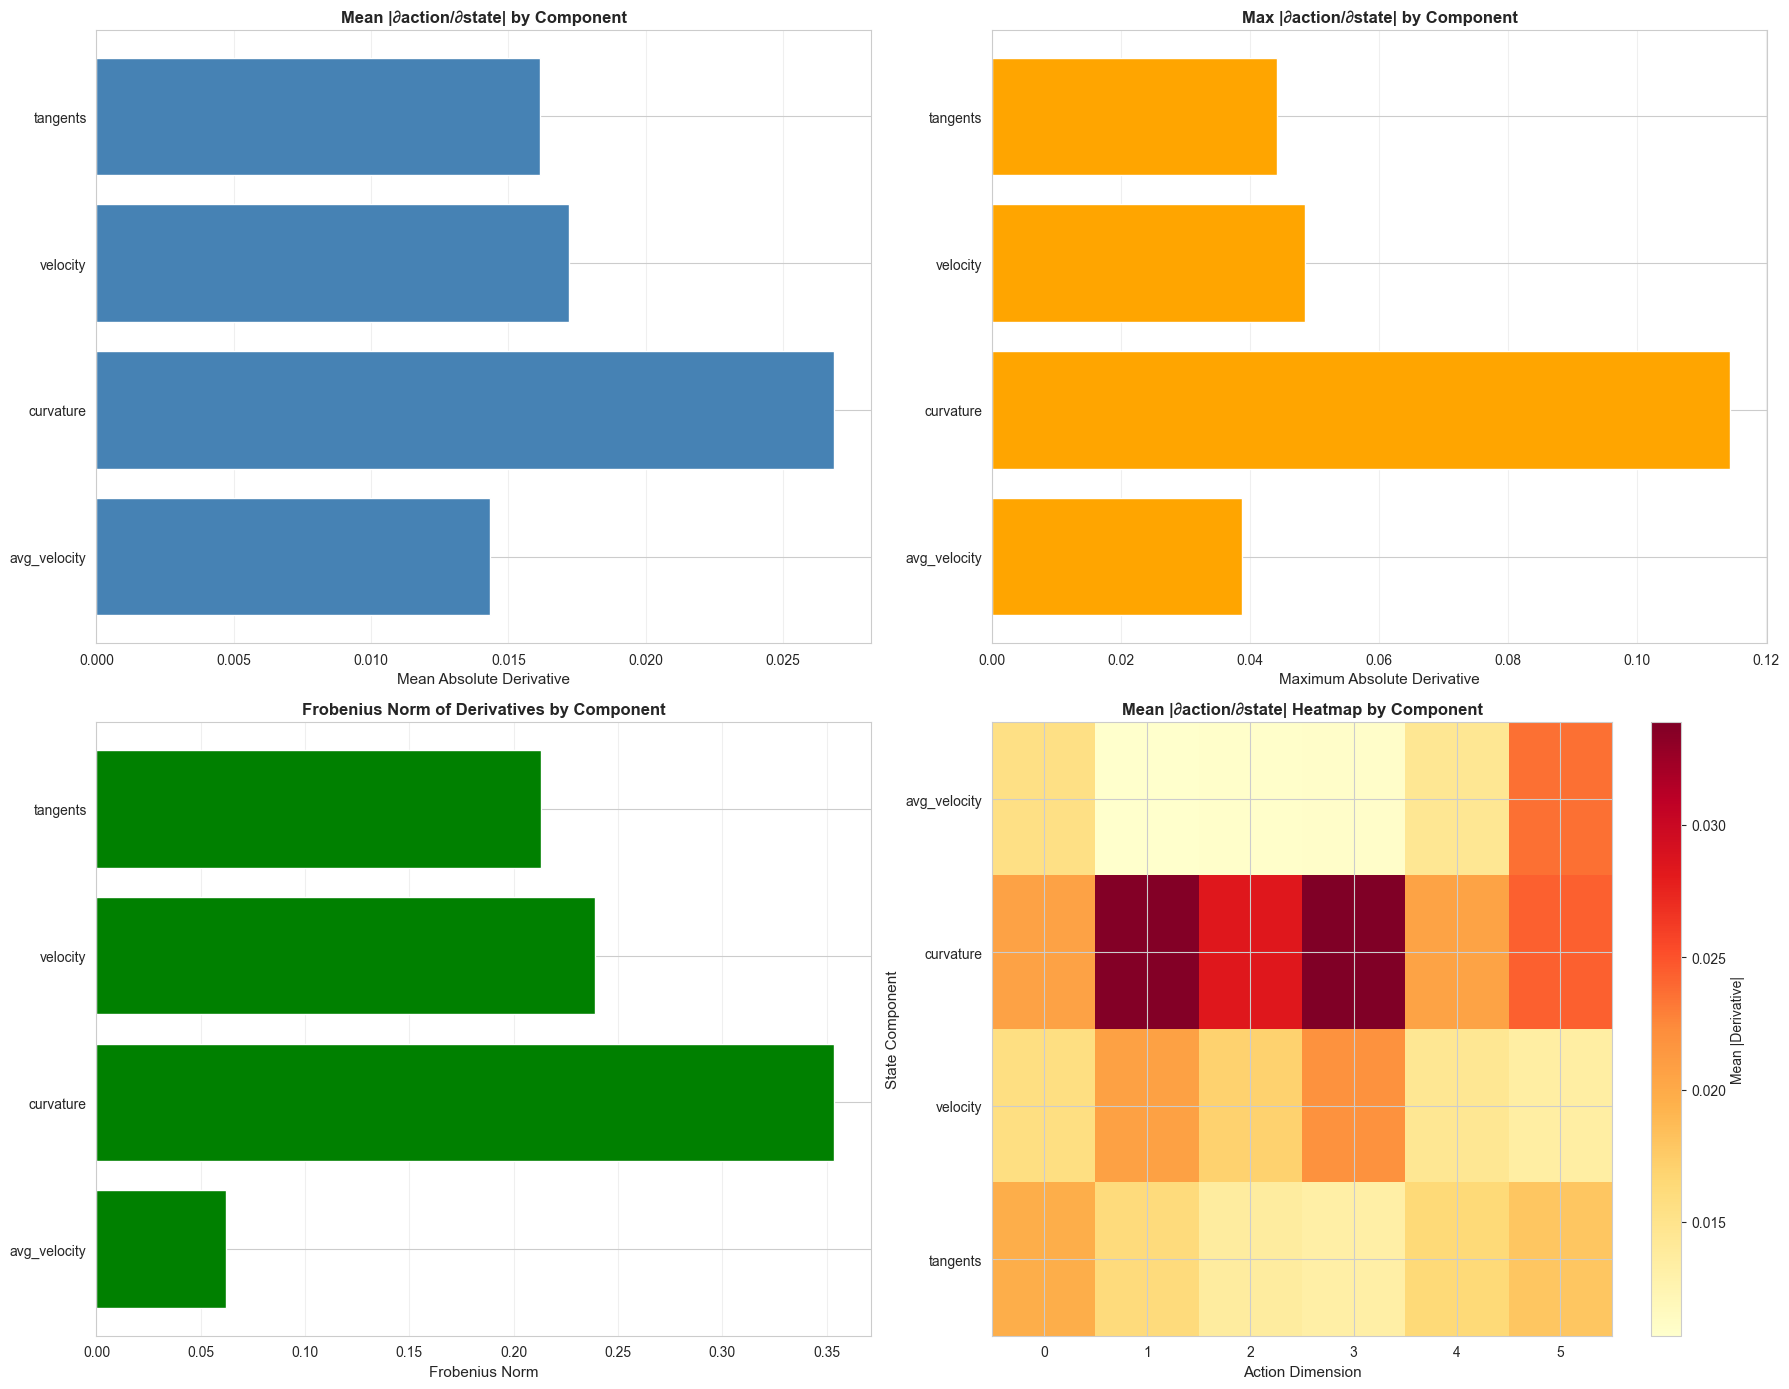

In [9]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Mean absolute derivatives
ax = axes[0, 0]
components = list(component_stats.keys())
means = [component_stats[c]['mean'] for c in components]
ax.barh(components, means, color='steelblue')
ax.set_xlabel('Mean Absolute Derivative', fontsize=11)
ax.set_title('Mean |∂action/∂state| by Component', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# 2. Maximum absolute derivatives
ax = axes[0, 1]
maxs = [component_stats[c]['max'] for c in components]
ax.barh(components, maxs, color='orange')
ax.set_xlabel('Maximum Absolute Derivative', fontsize=11)
ax.set_title('Max |∂action/∂state| by Component', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# 3. Norm of derivatives
ax = axes[1, 0]
norms = [component_stats[c]['norm'] for c in components]
ax.barh(components, norms, color='green')
ax.set_xlabel('Frobenius Norm', fontsize=11)
ax.set_title('Frobenius Norm of Derivatives by Component', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# 4. Heatmap for each component
ax = axes[1, 1]
# Create a summary matrix: rows = components, cols = actions
summary_matrix = np.zeros((len(components), jacobian.shape[0]))
for i, key in enumerate(components):
    start, end = state_component_indices[key]
    # Use mean absolute value across state variables in this component
    summary_matrix[i, :] = np.mean(np.abs(jacobian[:, start:end]), axis=1)

im = ax.imshow(summary_matrix, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax.set_yticks(range(len(components)))
ax.set_yticklabels(components)
ax.set_xlabel('Action Dimension', fontsize=11)
ax.set_ylabel('State Component', fontsize=11)
ax.set_title('Mean |∂action/∂state| Heatmap by Component', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax, label='Mean |Derivative|')

plt.tight_layout()
plt.show()


## 10. Derivatives for Each Action Dimension

Plot derivatives for each action dimension separately to see which state variables most influence each action.


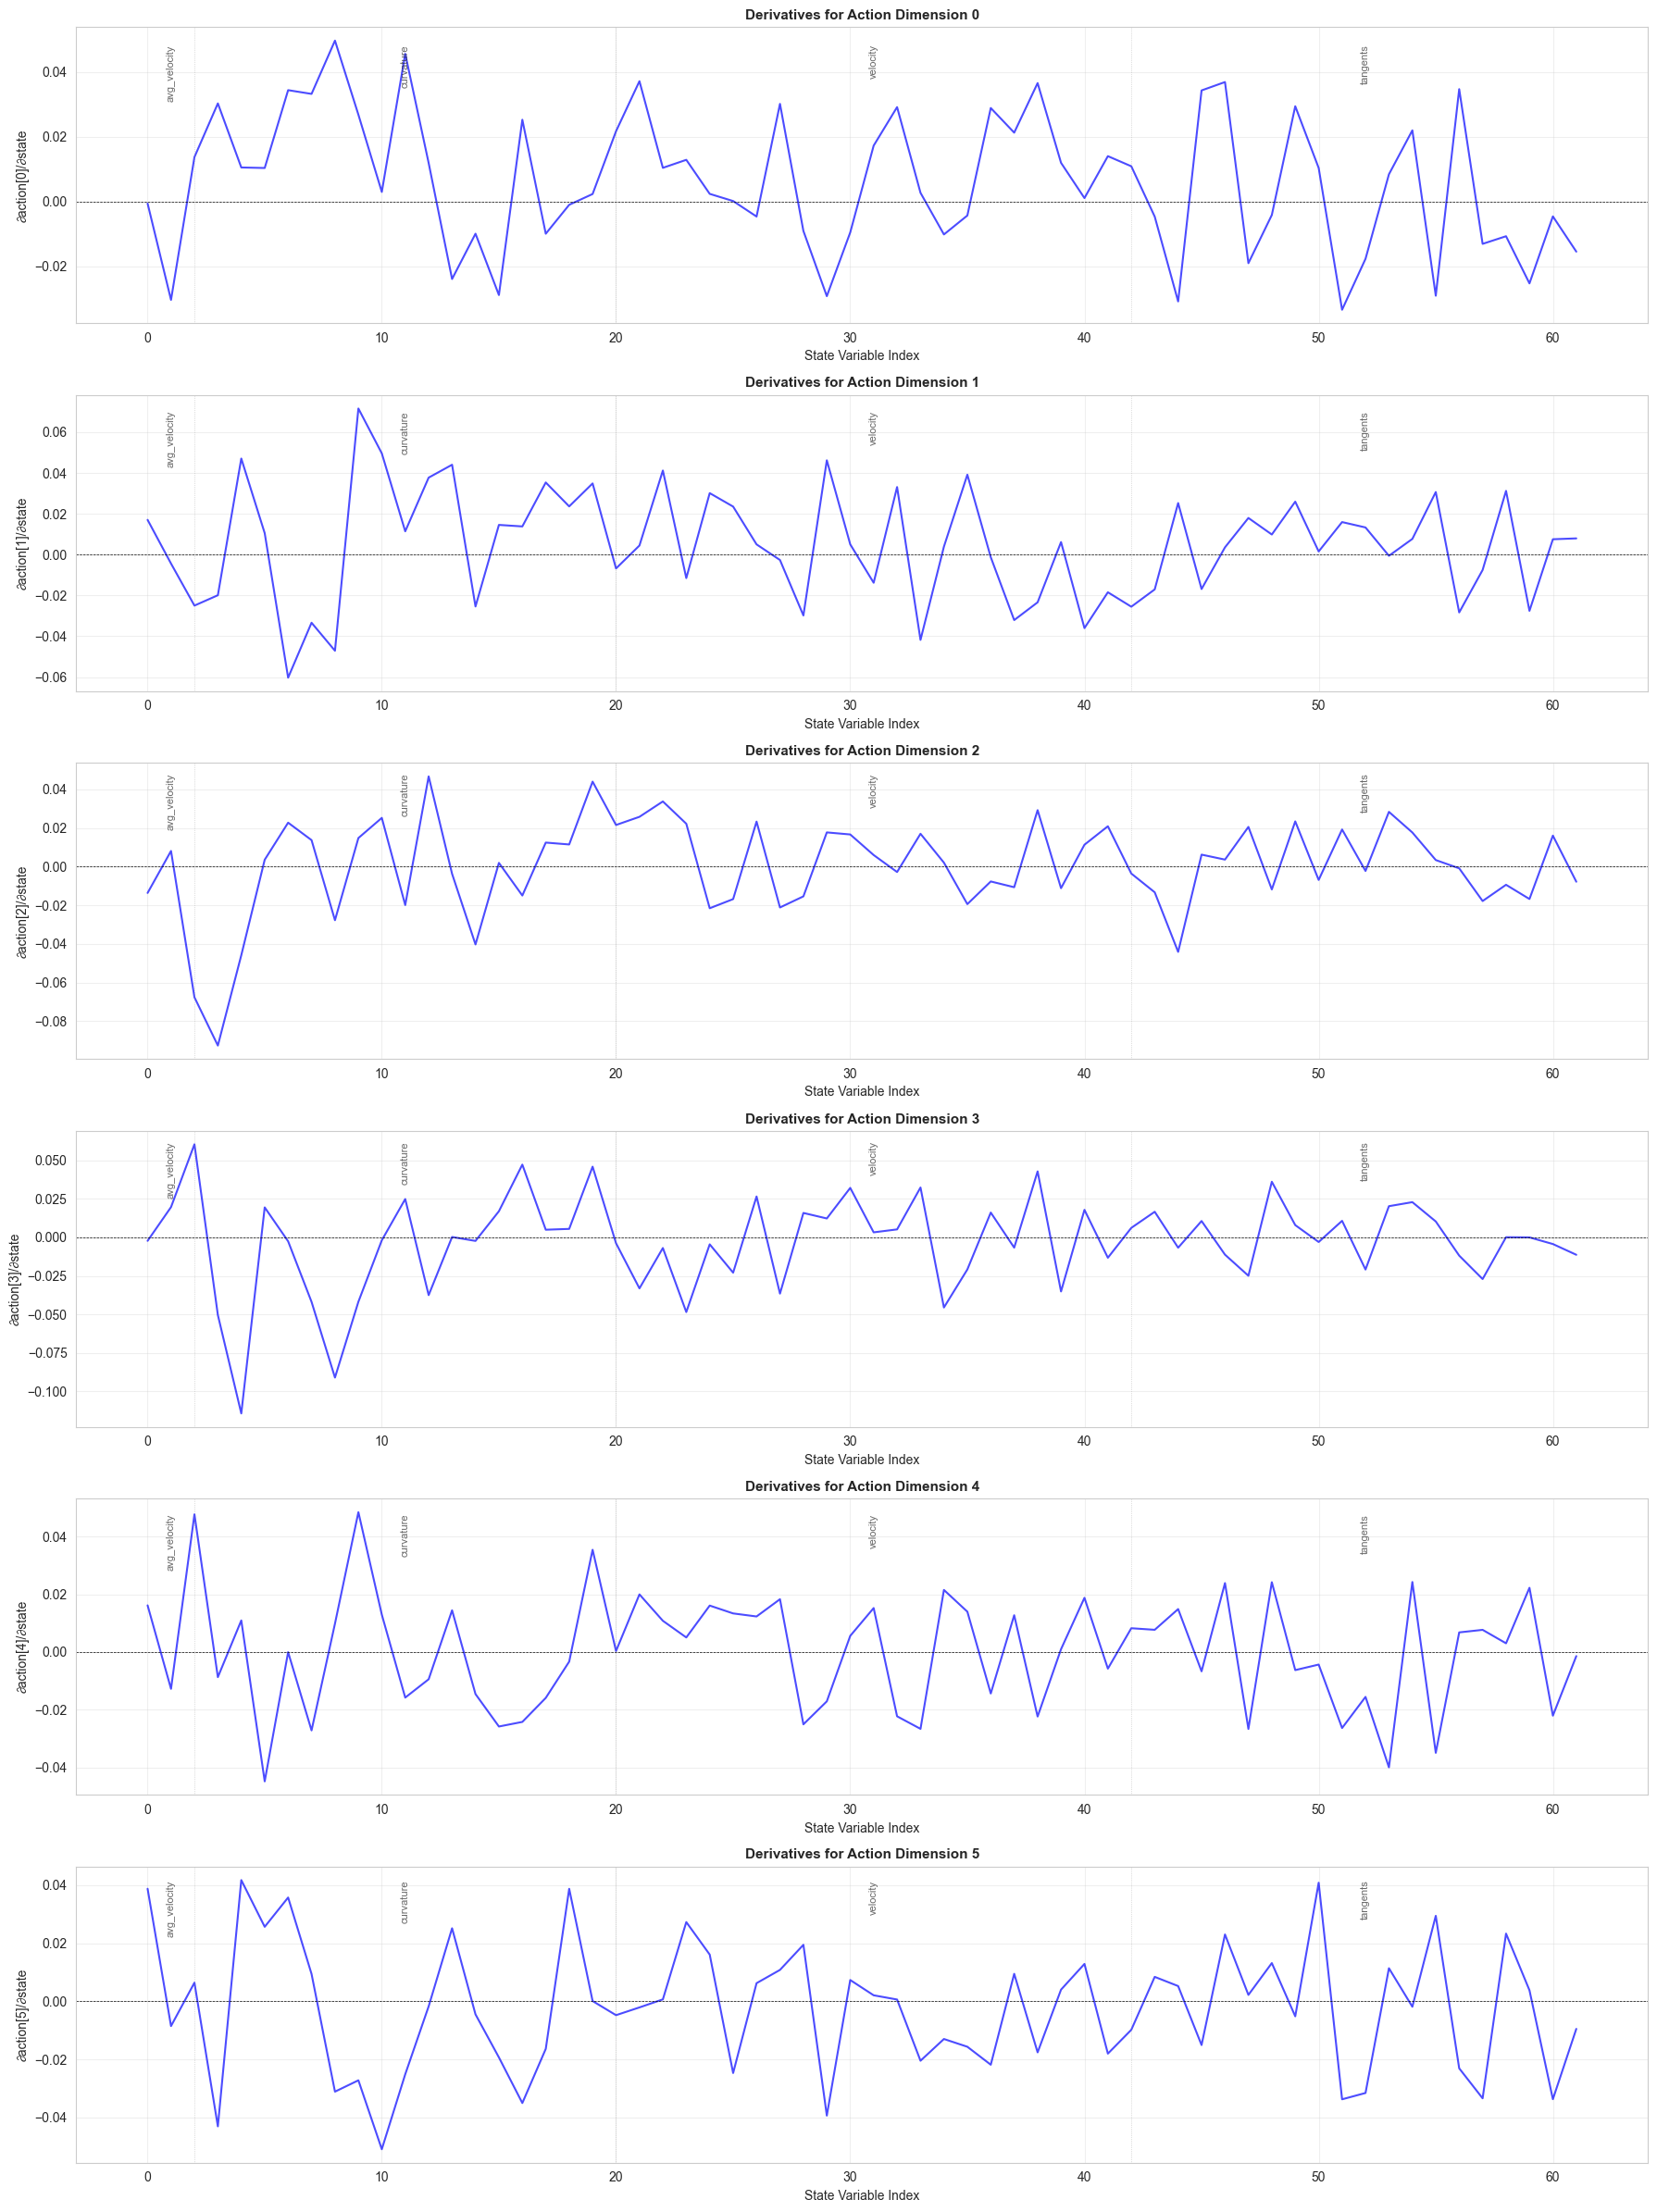


Derivative statistics for each action dimension:
Action     Mean |∂|     Max |∂|      Std          Norm        
Action[0]: 0.018408     0.049713     0.021381     0.175319    
Action[1]: 0.022645     0.071597     0.027177     0.217174    
Action[2]: 0.018984     0.092557     0.024774     0.195070    
Action[3]: 0.022208     0.114356     0.030633     0.242443    
Action[4]: 0.016830     0.048415     0.020189     0.158967    
Action[5]: 0.018333     0.050911     0.022458     0.177685    


In [10]:
# Plot derivatives for each action dimension separately
num_actions = jacobian.shape[0]
fig, axes = plt.subplots(num_actions, 1, figsize=(18, 4 * num_actions))

if num_actions == 1:
    axes = [axes]

for action_idx in range(num_actions):
    ax = axes[action_idx]
    
    # Plot derivatives for this action
    ax.plot(jacobian[action_idx, :], linewidth=1.5, alpha=0.7, color='blue')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    
    # Add vertical lines to separate state components
    for key, (start, end) in state_component_indices.items():
        if start > 0:
            ax.axvline(x=start, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
        # Add labels for component boundaries
        if start < state_dim:
            ax.text(start + (end-start)/2, ax.get_ylim()[1]*0.9, key, 
                   rotation=90, ha='center', va='top', fontsize=8, alpha=0.7)
    
    ax.set_xlabel('State Variable Index', fontsize=10)
    ax.set_ylabel(f'∂action[{action_idx}]/∂state', fontsize=10)
    ax.set_title(f'Derivatives for Action Dimension {action_idx}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics for each action
print("\nDerivative statistics for each action dimension:")
print("=" * 80)
print(f"{'Action':<10s} {'Mean |∂|':<12s} {'Max |∂|':<12s} {'Std':<12s} {'Norm':<12s}")
print("=" * 80)
for action_idx in range(num_actions):
    action_grad = jacobian[action_idx, :]
    print(f"Action[{action_idx}]: {np.mean(np.abs(action_grad)):<12.6f} {np.max(np.abs(action_grad)):<12.6f} {np.std(action_grad):<12.6f} {np.linalg.norm(action_grad):<12.6f}")
print("=" * 80)


## 11. Detailed Derivatives for Each State Component

Visualize derivatives for each state component separately.


In [ ]:
# Create detailed plots for each state component
fig, axes = plt.subplots(len(obs_keys), 1, figsize=(18, 4 * len(obs_keys)))

if len(obs_keys) == 1:
    axes = [axes]

for comp_idx, key in enumerate(obs_keys):
    if key not in state_component_indices:
        continue
        
    ax = axes[comp_idx]
    start, end = state_component_indices[key]
    
    # Plot derivatives for all actions
    for action_idx in range(num_actions):
        ax.plot(
            range(start, end),
            jacobian[action_idx, start:end],
            label=f'Action[{action_idx}]',
            linewidth=1.5,
            alpha=0.7,
            marker='o',
            markersize=3
        )
    
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    ax.set_xlabel(f'{key} State Variable Index (within component)', fontsize=10)
    ax.set_ylabel('∂action/∂state', fontsize=10)
    ax.set_title(f'Derivatives for State Component: {key} (indices {start}-{end-1}, size={end-start})', 
                fontsize=11, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 12. Derivatives for Each Individual State Variable

Create a detailed table showing derivatives for each state variable.


In [ ]:
# Create a detailed table of derivatives
print("Detailed derivatives for each state variable:")
print("=" * 100)

# Print header
header = f"{'State Var':<12s} {'Component':<20s}"
for action_idx in range(num_actions):
    header += f" {'∂action[' + str(action_idx) + ']/∂state':<15s}"
header += f" {'|Max|':<10s}"
print(header)
print("=" * 100)

# Print derivatives for each state variable
for state_idx in range(min(20, state_dim)):  # Show first 20 state variables
    # Find which component this state variable belongs to
    component_name = "unknown"
    for key, (start, end) in state_component_indices.items():
        if start <= state_idx < end:
            component_name = key
            break
    
    row = f"{state_idx:<12d} {component_name:<20s}"
    max_abs = 0.0
    for action_idx in range(num_actions):
        deriv = jacobian[action_idx, state_idx]
        row += f" {deriv:>15.6f}"
        max_abs = max(max_abs, abs(deriv))
    row += f" {max_abs:>10.6f}"
    print(row)

if state_dim > 20:
    print(f"... (showing first 20 of {state_dim} state variables)")
print("=" * 100)


## 13. Top State Variables by Influence

Identify which state variables have the strongest influence on the policy.


In [ ]:
# Calculate influence for each state variable (using norm across all actions)
state_influences = []
for state_idx in range(state_dim):
    # Find which component this state variable belongs to
    component_name = "unknown"
    for key, (start, end) in state_component_indices.items():
        if start <= state_idx < end:
            component_name = key
            break
    
    # Calculate norm of derivatives for this state variable
    influence = np.linalg.norm(jacobian[:, state_idx])
    max_abs = np.max(np.abs(jacobian[:, state_idx]))
    
    state_influences.append({
        'index': state_idx,
        'component': component_name,
        'norm': influence,
        'max_abs': max_abs
    })

# Sort by influence
state_influences.sort(key=lambda x: x['norm'], reverse=True)

# Display top 20 most influential state variables
print("Top 20 most influential state variables:")
print("=" * 80)
print(f"{'Rank':<6s} {'State Var':<12s} {'Component':<20s} {'Norm':<15s} {'Max |∂|':<15s}")
print("=" * 80)
for rank, info in enumerate(state_influences[:20], 1):
    print(f"{rank:<6d} {info['index']:<12d} {info['component']:<20s} {info['norm']:<15.6f} {info['max_abs']:<15.6f}")
print("=" * 80)


## 14. Visualize Top Influential State Variables


In [ ]:
# Visualize top influential state variables
top_n = 20
top_indices = [info['index'] for info in state_influences[:top_n]]
top_norms = [info['norm'] for info in state_influences[:top_n]]
top_components = [info['component'] for info in state_influences[:top_n]]

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 1. Bar plot of top influential state variables
ax = axes[0]
colors = plt.cm.tab10(np.linspace(0, 1, len(set(top_components))))
component_to_color = {comp: colors[i % len(colors)] for i, comp in enumerate(set(top_components))}
bar_colors = [component_to_color[comp] for comp in top_components]

bars = ax.barh(range(top_n), top_norms, color=bar_colors)
ax.set_yticks(range(top_n))
ax.set_yticklabels([f"State[{idx}] ({comp})" for idx, comp in zip(top_indices, top_components)], fontsize=9)
ax.set_xlabel('Influence (Norm of Derivatives)', fontsize=11)
ax.set_title(f'Top {top_n} Most Influential State Variables', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

# 2. Heatmap of derivatives for top state variables
ax = axes[1]
top_jacobian = jacobian[:, top_indices]
im = ax.imshow(top_jacobian, aspect='auto', cmap='RdBu_r', interpolation='nearest')
ax.set_xticks(range(top_n))
ax.set_xticklabels([f"{idx}\n({comp})" for idx, comp in zip(top_indices, top_components)], 
                   rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Action Dimension', fontsize=11)
ax.set_xlabel('State Variable Index (Component)', fontsize=11)
ax.set_title(f'Derivatives for Top {top_n} State Variables', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax, label='Derivative Value')

plt.tight_layout()
plt.show()


## 15. Compute Derivatives for Multiple States

Compute derivatives for multiple sample states to see how they vary.


In [ ]:
# Compute Jacobians for all sample states
print(f"Computing Jacobians for {len(sample_states)} sample states...")
all_jacobians = []
for i, sample_state in enumerate(sample_states):
    jac = compute_policy_jacobian(model, sample_state)
    all_jacobians.append(jac)
    if (i + 1) % 5 == 0:
        print(f"  Computed {i + 1}/{len(sample_states)}")

all_jacobians = np.array(all_jacobians)
print(f"\nComputed {len(all_jacobians)} Jacobian matrices")
print(f"Shape: {all_jacobians.shape}")

# Compute statistics across states
mean_jacobian = np.mean(all_jacobians, axis=0)
std_jacobian = np.std(all_jacobians, axis=0)

print(f"\nStatistics across {len(sample_states)} states:")
print(f"Mean Jacobian - Min: {mean_jacobian.min():.6f}, Max: {mean_jacobian.max():.6f}, Mean: {mean_jacobian.mean():.6f}")
print(f"Std Jacobian - Min: {std_jacobian.min():.6f}, Max: {std_jacobian.max():.6f}, Mean: {std_jacobian.mean():.6f}")

# Visualize mean and std
fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# Mean Jacobian
ax = axes[0]
im = ax.imshow(mean_jacobian, aspect='auto', cmap='RdBu_r', interpolation='nearest')
ax.set_xlabel('State Variable Index', fontsize=12)
ax.set_ylabel('Action Dimension', fontsize=12)
ax.set_title('Mean Jacobian Matrix Across Sample States', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='Mean Derivative Value')

# Std Jacobian
ax = axes[1]
im = ax.imshow(std_jacobian, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax.set_xlabel('State Variable Index', fontsize=12)
ax.set_ylabel('Action Dimension', fontsize=12)
ax.set_title('Std Dev of Jacobian Matrix Across Sample States', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='Std Dev of Derivative')

plt.tight_layout()
plt.show()


## 16. Summary and Key Findings


In [ ]:
print("=" * 80)
print("SUMMARY OF POLICY DERIVATIVES ANALYSIS")
print("=" * 80)

print(f"\n1. Policy Structure:")
print(f"   - Action dimensions: {jacobian.shape[0]}")
print(f"   - State dimensions: {jacobian.shape[1]}")

print(f"\n2. Overall Sensitivity:")
print(f"   - Mean absolute derivative: {np.mean(np.abs(jacobian)):.6f}")
print(f"   - Max absolute derivative: {np.max(np.abs(jacobian)):.6f}")
print(f"   - Frobenius norm: {np.linalg.norm(jacobian):.6f}")

print(f"\n3. Most Sensitive State Components:")
sorted_components = sorted(component_stats.items(), key=lambda x: x[1]['norm'], reverse=True)
for i, (key, stats) in enumerate(sorted_components[:3], 1):
    print(f"   {i}. {key}: norm={stats['norm']:.6f}, mean|∂|={stats['mean']:.6f}")

print(f"\n4. Most Influential State Variables:")
for i, info in enumerate(state_influences[:5], 1):
    print(f"   {i}. State[{info['index']}] ({info['component']}): norm={info['norm']:.6f}")

print(f"\n5. Action Sensitivity:")
for action_idx in range(num_actions):
    action_grad = jacobian[action_idx, :]
    print(f"   Action[{action_idx}]: mean|∂|={np.mean(np.abs(action_grad)):.6f}, norm={np.linalg.norm(action_grad):.6f}")

print("\n" + "=" * 80)
